#### dependencies
---

In [1]:
#matplotlib/graph
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
#data-oriented
import pandas as pd

In [3]:
file_sql = 'hawaii.sqlite'

In [4]:
#SQLalchemy toolkit, ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#### reflect into SQLAlchemy ORM
---

In [5]:
#engine, connection, inspector
engine = create_engine(f'sqlite:///Resources/hawaii.sqlite')
conn = engine.connect()
inspector = inspect(engine)

In [6]:
#reflect existing database
Base = automap_base()
#reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
#establish session
session = Session(engine)

In [8]:
#view classes (ie. tables)
Base.classes.keys()

['measurement', 'station']

In [9]:
#save reference to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
col_measure = inspector.get_columns('measurement')
col_station = inspector.get_columns('station')

In [11]:
#measurement keys
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [12]:
#station keys
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [13]:
#read measurement table into df to see last date 
#(does not work with full date)
tbl_measure = pd.read_sql('SELECT * FROM measurement WHERE date >= 2017', conn)
tbl_measure.sort_values('date', ascending=False).head()

,id,station,date,prcp,tobs
1396,19550,USC00516128,2017-08-23,0.45,76.0
953,12187,USC00519523,2017-08-23,0.08,82.0
636,7635,USC00514830,2017-08-23,0.00,82.0
229,2724,USC00519397,2017-08-23,0.00,81.0
1395,19549,USC00516128,2017-08-22,0.50,76.0


In [14]:
#read stations table into df
tbl_station = pd.read_sql('SELECT * FROM station', conn)
tbl_station

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


#### exploratory analysis
---

In [15]:
#query last 12 months of precipitation data and plot the results
prcp_2017 = session.query(Measurement.prcp, Measurement.date, Measurement.station).filter(Measurement.date > '2016-08-23').all()

#query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(prcp_2017)

#convert date col to dt
df_prcp['date'] = pd.to_datetime(df_prcp['date'])

#sort by date
df_prcp.sort_values('date')

#groupby.agg makes a more succinct graph (does combine all data for each day)
group_prcp = df_prcp.groupby('date').agg('sum')

In [16]:
#view
df_prcp.head()

,prcp,date,station
0,0.08,2016-08-24,USC00519397
1,0.08,2016-08-25,USC00519397
2,0.00,2016-08-26,USC00519397
3,0.00,2016-08-27,USC00519397
4,0.01,2016-08-28,USC00519397


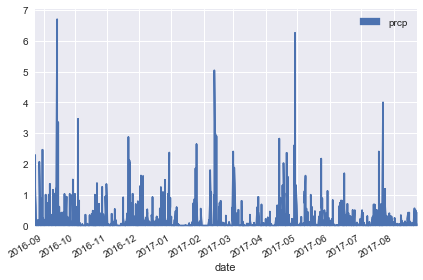

In [17]:
#plot full df
df_prcp.plot(kind='area', x='date',y='prcp')
plt.tight_layout()
plt.show()

In [18]:
group_prcp.head()

,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


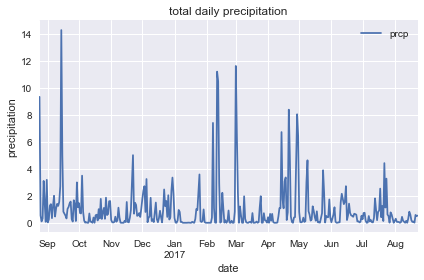

In [19]:
#plot groupby
group_prcp.reset_index().plot(kind='line', x='date',y='prcp', title='total daily precipitation')
plt.ylabel('precipitation')
plt.tight_layout()
plt.show()

In [20]:
#pandas to calculate the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
#count df query
tbl_station['station'].count()

#count sqlalchemy query
stations = session.query(Station.station).all()
print(f' There are {len(stations)} stations.')

 There are 9 stations.


In [22]:
#in pandas
data_count = session.query(Measurement.id, Measurement.station).all()
df_count = pd.DataFrame(data_count)
df_count.groupby('station').agg('count').sort_values('id', ascending=False)

,id
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [23]:
#sqlalchemy query to find same data
query_station = session.query(func.count(Station.station)).first()
query_station_all = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

#display stations in most active/desc order
query_station_all

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
#calculate: lowest, highest, average temperature for most active station

#USC00519281 tobs--min, max, avg
query_top_elements = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()

query_top_elements

[(54.0, 85.0, 71.66378066378067)]

In [25]:
#USC00519281 tobs--1 year (highest number of temperature observations)
query_top = session.query(Measurement.station, Measurement.tobs, Measurement.date)\
    .filter(Measurement.station == 'USC00519281', Measurement.date >= '2016-08-23').all()

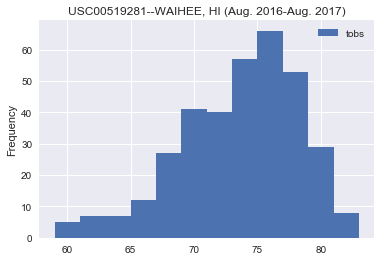

In [26]:
#histogram for USC00519281
df_top_year = pd.DataFrame(query_top)
df_top_year.plot.hist(bins=12)
plt.title('USC00519281--WAIHEE, HI (Aug. 2016-Aug. 2017)')
plt.show()